Test CNN on spectrogram

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import time
import numpy as np
import torch.utils.data as data_utils
import torch.nn.functional as F

from scipy import signal
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%run scripts/readEDF.py
%run scripts/spectrogramData.py

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

### Load Data

In [3]:
# Saving the organized data for use in CNN (python 3)
%run scripts/readEDF.py
df_dict = read_patient_edf('chb01')

/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_01.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_02.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_03.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_04.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_05.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_06.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_07.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_08.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_09.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_10.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_11.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_12.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_13.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data/chb01/chb01_14.edf
/mnt/c/Users/choec/Documents/GitHub/ANES212_data

In [4]:
%run scripts/spectrogramData.py
start = time.time()
features, targets, dt = df_to_spectrogram_FT(df_dict, sliding=False, npserseg=256, noverlap=32, width=8, stft = True)
print(time.time() - start)
print(features.shape, targets.shape)

128.87664771080017
(20802, 23, 128, 8) (20802, 1)


In [124]:
dt

0.875

Organize data into something useable

In [5]:
def split_train_test_kfold(features_og, targets_og, k_fold=1, num_repeat=250):
#     features_og = np.load(feature_filename)
#     targets_og = np.load(target_filename)
    print(sum(targets_og),targets_og.shape)

    # Split data into train and test
    split = np.arange(len(targets_og))
    np.random.shuffle(split)
    features_og = features_og[split]
    targets_og = targets_og[split]
    features_og_0 = features_og[np.where(targets_og==0)[0]]
    features_og_1 = features_og[np.where(targets_og==1)[0]]
    targets_og_0 = targets_og[np.where(targets_og==0)[0]]
    targets_og_1 = targets_og[np.where(targets_og==1)[0]]
    N_0 = len(targets_og_0)
    N_1 = len(targets_og_1)
    
    features_og_train = np.vstack([features_og_0,features_og_1])
    targets_og_train = np.vstack([targets_og_0,targets_og_1])
    sample_list = []
    
    num_seizure_per = float(N_1)//k_fold
    num_remainder = float(N_1) % k_fold
    for i in range(k_fold):
        if (i+1)==k_fold:
            temp1 = np.arange(i*N_0//k_fold,N_0, dtype=np.int64)
            temp2 = np.arange(i*N_1//k_fold,N_1, dtype=np.int64)+N_0
        else:
            temp1 = np.arange(i*N_0//k_fold,(i+1)*N_0//k_fold, dtype=np.int64)
            temp2 = np.arange(i*N_1//k_fold,(i+1)*N_1//k_fold, dtype=np.int64)+N_0
        temp2 = np.repeat(temp2,num_repeat)
        sample_list.append(np.hstack([temp1,temp2]))
    
    train_sampler_list = []
    test_sampler_list = []
    for i in range(k_fold):
        temp = np.where(np.arange(len(sample_list), dtype=np.int64) != i)[0]
        train =  np.hstack([sample_list[x] for x in temp])
        test = sample_list[i]
        train_sampler_list.append(SubsetRandomSampler(train))
        test_sampler_list.append(SubsetRandomSampler(test))
        
    # Convert data to tensor dataset
    features = torch.from_numpy(features_og_train).float()
    targets = torch.from_numpy(targets_og_train).long()
    targets = torch.squeeze(targets)
    train = data_utils.TensorDataset(features, targets)
    
    return train_sampler_list, test_sampler_list, train
    
def split_train_test(train_percent, k_fold=0):
    features_og = np.load('features_nonsliding_ch.npy')
    targets_og = np.load('targets_nonsliding_ch.npy')
    print(sum(targets_og),targets_og.shape)

    # Split data into train and test
    split = np.arange(len(targets_og))
    np.random.shuffle(split)
    features_og = features_og[split]
    targets_og = targets_og[split]
    features_og_0 = features_og[np.where(targets_og==0)[0]]
    features_og_1 = features_og[np.where(targets_og==1)[0]]
    targets_og_0 = targets_og[np.where(targets_og==0)[0]]
    targets_og_1 = targets_og[np.where(targets_og==1)[0]]
    N_0 = len(targets_og_0)
    N_1 = len(targets_og_1)
    
    features_og_train = np.vstack([features_og_0[:int(train_percent*N_0)],features_og_1[:int(train_percent*N_1)]])
    targets_og_train = np.vstack([targets_og_0[:int(train_percent*N_0)],targets_og_1[:int(train_percent*N_1)]])
    features_og_test = np.vstack([features_og_0[int(train_percent*N_0):],features_og_1[int(train_percent*N_1):]])
    targets_og_test = np.vstack([targets_og_0[int(train_percent*N_0):],targets_og_1[int(train_percent*N_1):]])
    print(sum(targets_og_train), sum(targets_og_test))
    

    # Balance dataset
    # ~1/4000 seizure events
    idx = np.hstack([np.where(targets_og_train == 0)[0], 
                     np.repeat(np.where(targets_og_train == 1)[0], 100)]) # Oversample
    features = features_og_train[idx]
    targets = targets_og_train[idx]

    # Convert data to tensor dataset
    features = torch.from_numpy(features).float()
    targets = torch.from_numpy(targets).long()
    targets = torch.squeeze(targets)
    train = data_utils.TensorDataset(features, targets)

    N = features.size()[0]
    sample_list = np.arange(N, dtype=np.int64)
    np.random.shuffle(sample_list)
    percent_train = 1.0

    #Training
    n_training_samples = int(N*percent_train)
    train_sampler = SubsetRandomSampler(sample_list[:n_training_samples])

    #Validation
    val_sampler = SubsetRandomSampler(sample_list[:n_training_samples])

    #Test data
    features = torch.from_numpy(features_og_test).float()
    targets = torch.from_numpy(targets_og_test).long()
    targets = torch.squeeze(targets)
    test = data_utils.TensorDataset(features, targets)
    return train, test, train_sampler, val_sampler

In [8]:
class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 1, output channels = 18
        self.conv1 = torch.nn.Conv2d(23, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        
        #64 input features, 2 output features
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 32, 32) to (18, 16, 16)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 16 *16)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [11]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size, train_sampler):
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)
    return(train_loader)

#Test and validation loaders have constant batch sizes, so we can define them directly

def trainNet(net, train_sampler, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size, train_sampler)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            
            #Get inputs
            inputs, labels = data
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data[0]
            total_train_loss += loss_size.data[0]
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.6f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        #At the end of the epoch, do a pass on the validation set
#         total_val_loss = 0
#         for inputs, labels in val_loader:            
#             #Wrap tensors in Variables
#             inputs, labels = Variable(inputs), Variable(labels)
            
#             #Forward pass
#             val_outputs = net(inputs)
#             val_loss_size = loss(val_outputs, labels)
#             total_val_loss += val_loss_size.data[0]
            
#         print("Validation loss = {:.2f}".format(total_val_loss / max(1,len(val_loader))))
        

        print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
        
def calculate_cm(test_sampler):
    test_loader = torch.utils.data.DataLoader(train, sampler=test_sampler, batch_size=2)
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data          
            outputs = CNN(images)
            _, predicted = torch.max(outputs.data, 1)
            for x,y in zip(predicted, labels):
                y_true.append(int(y.numpy()))
                y_pred.append(int(x.numpy()))
    return confusion_matrix(np.array(y_true), np.array(y_pred))

In [121]:
# cross validation
k_fold = 5
batch_size = 8
features_og = features
targets_og = targets

train_sampler_list, test_sampler_list, train = split_train_test_kfold(features_og , targets_og, k_fold=k_fold)

cm = np.zeros((2,2))
for train_sampler, test_sampler in zip(train_sampler_list, test_sampler_list):
    CNN = SimpleCNN()
    val_loader = torch.utils.data.DataLoader(train, batch_size=32, sampler=train_sampler, num_workers=2)
    trainNet(CNN, train_sampler, batch_size=batch_size, n_epochs=10, learning_rate=1e-6)# 2,5,1e-6 
    cm += calculate_cm(test_sampler)
    print(cm)

tn, fp, fn, tp = cm.ravel()
fn=fn/250
tp=tp/250
acc = (tp+tn)/(tn+fp+fn+tp)
sen = tp/(tp+fn)
spec = tn/(tn+fp)
prec = tp/(tp+fp)
F1 = 2 * (prec * sen) / (prec + sen)

print(cm)
print('accuracy: ',acc)
print('sensitivity:', sen)
print('specificity:', spec)
print('precision:', prec)
print('F1:', F1)

[70.] (20802, 1)
===== HYPERPARAMETERS =====
batch_size= 8
epochs= 10
learning_rate= 1e-06


/home/cachoe/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/cachoe/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 1, 10% 	 train_loss: 1.289805 took: 7.05s
Epoch 1, 20% 	 train_loss: 0.381736 took: 3.68s
Epoch 1, 30% 	 train_loss: 0.274537 took: 3.56s
Epoch 1, 40% 	 train_loss: 0.217319 took: 3.25s
Epoch 1, 50% 	 train_loss: 0.165023 took: 3.24s
Epoch 1, 60% 	 train_loss: 0.135304 took: 3.49s
Epoch 1, 70% 	 train_loss: 0.113232 took: 3.33s
Epoch 1, 80% 	 train_loss: 0.093213 took: 3.24s
Epoch 1, 90% 	 train_loss: 0.083649 took: 3.15s
Training finished, took 37.21s
Epoch 2, 10% 	 train_loss: 0.060304 took: 4.96s
Epoch 2, 20% 	 train_loss: 0.054846 took: 3.79s
Epoch 2, 30% 	 train_loss: 0.047181 took: 3.55s
Epoch 2, 40% 	 train_loss: 0.042093 took: 3.43s
Epoch 2, 50% 	 train_loss: 0.037386 took: 3.65s
Epoch 2, 60% 	 train_loss: 0.031432 took: 3.38s
Epoch 2, 70% 	 train_loss: 0.031330 took: 3.49s
Epoch 2, 80% 	 train_loss: 0.028859 took: 3.34s
Epoch 2, 90% 	 train_loss: 0.022574 took: 3.61s
Training finished, took 73.64s
Epoch 3, 10% 	 train_loss: 0.021165 took: 4.77s
Epoch 3, 20% 	 train_loss:

Epoch 8, 50% 	 train_loss: 0.002882 took: 3.20s
Epoch 8, 60% 	 train_loss: 0.001491 took: 3.52s
Epoch 8, 70% 	 train_loss: 0.001583 took: 3.13s
Epoch 8, 80% 	 train_loss: 0.004057 took: 3.22s
Epoch 8, 90% 	 train_loss: 0.002075 took: 3.46s
Training finished, took 291.66s
Epoch 9, 10% 	 train_loss: 0.001578 took: 4.92s
Epoch 9, 20% 	 train_loss: 0.001198 took: 3.47s
Epoch 9, 30% 	 train_loss: 0.003437 took: 3.24s
Epoch 9, 40% 	 train_loss: 0.000906 took: 3.24s
Epoch 9, 50% 	 train_loss: 0.002323 took: 3.26s
Epoch 9, 60% 	 train_loss: 0.002585 took: 3.44s
Epoch 9, 70% 	 train_loss: 0.001559 took: 3.75s
Epoch 9, 80% 	 train_loss: 0.000987 took: 3.22s
Epoch 9, 90% 	 train_loss: 0.000923 took: 3.24s
Training finished, took 326.62s
Epoch 10, 10% 	 train_loss: 0.001207 took: 5.01s
Epoch 10, 20% 	 train_loss: 0.003666 took: 3.84s
Epoch 10, 30% 	 train_loss: 0.001234 took: 3.28s
Epoch 10, 40% 	 train_loss: 0.001399 took: 3.62s
Epoch 10, 50% 	 train_loss: 0.000833 took: 3.40s
Epoch 10, 60% 	 tra

Epoch 5, 50% 	 train_loss: 0.004455 took: 3.07s
Epoch 5, 60% 	 train_loss: 0.005849 took: 3.18s
Epoch 5, 70% 	 train_loss: 0.003941 took: 3.12s
Epoch 5, 80% 	 train_loss: 0.003400 took: 4.11s
Epoch 5, 90% 	 train_loss: 0.008012 took: 3.92s
Training finished, took 179.70s
Epoch 6, 10% 	 train_loss: 0.003260 took: 4.87s
Epoch 6, 20% 	 train_loss: 0.002603 took: 3.14s
Epoch 6, 30% 	 train_loss: 0.002665 took: 3.09s
Epoch 6, 40% 	 train_loss: 0.005235 took: 3.13s
Epoch 6, 50% 	 train_loss: 0.004319 took: 3.11s
Epoch 6, 60% 	 train_loss: 0.002243 took: 3.10s
Epoch 6, 70% 	 train_loss: 0.002250 took: 3.19s
Epoch 6, 80% 	 train_loss: 0.002198 took: 3.13s
Epoch 6, 90% 	 train_loss: 0.005327 took: 3.15s
Training finished, took 212.71s
Epoch 7, 10% 	 train_loss: 0.001882 took: 4.38s
Epoch 7, 20% 	 train_loss: 0.004054 took: 3.35s
Epoch 7, 30% 	 train_loss: 0.001929 took: 3.45s
Epoch 7, 40% 	 train_loss: 0.003027 took: 3.07s
Epoch 7, 50% 	 train_loss: 0.005544 took: 3.24s
Epoch 7, 60% 	 train_los

In [9]:
# Save model
CNN = torch.load('CNN.model')

In [ ]:
tn, fp, fn, tp = cm.ravel()
fn=fn/250
tp=tp/250
acc = (tp+tn)/(tn+fp+fn+tp)
sen = tp/(tp+fn)
spec = tn/(tn+fp)
prec = tp/(tp+fp)
F1 = 2 * (prec * sen) / (prec + sen)

print(cm)
print('accuracy: ',acc)
print('sensitivity:', sen)
print('specificity:', spec)
print('precision:', prec)
print('F1:', F1)

In [133]:
cm = confusion_matrix(np.array(y_true), np.array(y_pred))
    
test_loader = torch.utils.data.DataLoader(test, batch_size=2)
cm = np.zeros((2,2))
total=0
correct=0
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data          
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for x,y in zip(predicted, labels):
            y_true.append(int(y.numpy()))
            y_pred.append(int(x.numpy()))
            
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

cm = confusion_matrix(np.array(y_true), np.array(y_pred))
tn, fp, fn, tp = cm.ravel()
acc = (tp+tn)/(tn+fp+fn+tp)
sen = tp/(tp+fn)
spec = tn/(tn+fp)
prec = tp/(tp+fp)
F1 = 2 * (prec * sen) / (prec + sen)

print(cm)
print('accuracy: ',acc)
print('sensitivity:', sen)
print('specificity:', spec)
print('precision:', prec)
print('F1:', F1)

NameError: name 'y_true' is not defined

### Visualize CNN running on an actual file

In [ ]:
df_t = {}
df_t['1'] = read_single_edf('chb01_03') # Figure out how to do python 2 wrapp
width = 8

feature, target = df_to_spectrogram_FT(df, sliding=True, avg=True, sliding_ft=False, width=8, stft=True)

# Convert feature to tensor
# Run it into the CNN 

### Visualize some example of CNN labeling

array([ 99110.])

In [17]:
limit = 10
train_sampler_list, test_sampler_list, train = split_train_test_kfold(features , targets, k_fold=10)
test_loader = get_train_loader(1, train_sampler_list[0])
features_og = features
targets_og = targets
count = 0
for i, data in enumerate(test_loader):
    if count > limit:
        break
    images, labels = data
    for x,y in zip(images,labels):
        x = x.numpy()
        y = y.numpy()
        outputs = CNN(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.numpy()[0]
        if y>0 and y<1:
            x=np.mean(x,axis=0)

            plt.pcolormesh(np.arange(x.shape[1])*0.875,np.arange(x.shape[0]),x)
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [sec]')
            plt.colorbar()
            if y:
                plt.title('Seizure Spectrogram (dB)')
            else:
                plt.title('Normal Spectrogram (dB)')
            plt.show()
            count += 1

[ 99110.] (20802, 1)


### Advanced imaging (Class specific image generation)
Cite: utkuozbulak/pytorch-cnn-visualizations


In [95]:
import os
import cv2
import copy
import numpy as np

from torch.optim import SGD
from torchvision import models
from torch.autograd import Variable
from torchvision import models

def preprocess_image(cv2im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel%3]#@
        im_as_arr[channel] /= std[channel%3]#@
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing

    Args:
        im_as_var (torch variable): Image to recreate

    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    # Convert RBG to GBR
    recreated_im = recreated_im[..., ::-1]
    return recreated_im

class ClassSpecificImageGeneration():
    """
        Produces an image that maximizes a certain class with gradient ascent
    """
    def __init__(self, model, target_class):
        self.mean = [-0.485, -0.456, -0.406]
        self.std = [1/0.229, 1/0.224, 1/0.225]
        self.model = model
        self.model.eval()
        self.target_class = target_class
        # Generate a random image
        self.created_image = np.uint8(np.random.uniform(0, 255, (8, 128, 23))) #@
        print(self.created_image.shape)
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def generate(self):
        initial_learning_rate = 6
        for i in range(1, 901):
            # Process image and return variable
            self.processed_image = preprocess_image(self.created_image)
            # Define optimizer for the image
            optimizer = SGD([self.processed_image], lr=initial_learning_rate)
            # Forward
            output = self.model(self.processed_image)
            # Target specific class
            class_loss = -output[0, self.target_class]
            #print('Iteration:', str(i), 'Loss', "{0:.2f}".format(class_loss.data.numpy()[0]))
            # Zero grads
            self.model.zero_grad()
            # Backward
            class_loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            # Save image
            if i%100 == 0:
                cv2.imwrite('../generated/c_specific_iteration_'+str(i)+'.jpg', self.created_image[:,:,0:3])
        return self.processed_image

In [96]:
target_class = 1  # Flamingo
pretrained_model = CNN
csig = ClassSpecificImageGeneration(pretrained_model, target_class)
img_s = csig.generate()

(8, 128, 23)


In [97]:
target_class = 0  # Flamingo
pretrained_model = CNN
csig = ClassSpecificImageGeneration(pretrained_model, target_class)
img_ns = csig.generate()

(8, 128, 23)


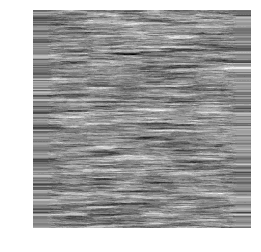

In [112]:
delta_img = img_s.detach().numpy()[0]-img_ns.detach().numpy()[0]
delta_img = np.mean(delta_img, axis = 0)
plt.imshow(delta_img.T, cmap='gray')
plt.axis('off')
plt.show()

In [117]:
import torch
from torch.nn import ReLU

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that it only returns positive gradients
        """
        def relu_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, changes it to zero
            """
            if isinstance(module, ReLU):
                return (torch.clamp(grad_in[0], min=0.0),)
        # Loop through layers, hook up ReLUs with relu_hook_function
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [119]:
if __name__ == '__main__':
    target_example = 0  # Snake
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_params(target_example)
    
    original_image = 
    pretrained_model = CNN
    # Guided backprop
    GBP = GuidedBackprop(pretrained_model)
    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, target_class)
    # Save colored gradients
    save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
    # Convert to grayscale
    grayscale_guided_grads = convert_to_grayscale(guided_grads)
    # Save grayscale gradients
    save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
    # Positive and negative saliency maps
    pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
    save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
    save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
    print('Guided backprop completed')

error: /home/travis/miniconda/conda-bld/conda_1486587069159/work/opencv-3.1.0/modules/imgproc/src/imgwarp.cpp:3229: error: (-215) ssize.area() > 0 in function resize


In [114]:
"""
Created on Thu Oct 21 11:09:09 2017

@author: Utku Ozbulak - github.com/utkuozbulak
"""
import os
import copy
import cv2
import numpy as np

import torch
from torch.autograd import Variable
from torchvision import models


def convert_to_grayscale(cv2im):
    """
        Converts 3d image to grayscale

    Args:
        cv2im (numpy arr): RGB image with shape (D,W,H)

    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(cv2im), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image

    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    gradient = np.uint8(gradient * 255).transpose(1, 2, 0)
    path_to_file = os.path.join('../results', file_name + '.jpg')
    # Convert RBG to GBR
    gradient = gradient[..., ::-1]
    cv2.imwrite(path_to_file, gradient)


def save_class_activation_on_image(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image

    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.jpg')
    cv2.imwrite(path_to_file, activation_map)
    # Heatmap of activation map
    activation_heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_HSV)
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.jpg')
    cv2.imwrite(path_to_file, activation_heatmap)
    # Heatmap on picture
    org_img = cv2.resize(org_img, (224, 224))
    img_with_heatmap = np.float32(activation_heatmap) + np.float32(org_img)
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.jpg')
    cv2.imwrite(path_to_file, np.uint8(255 * img_with_heatmap))


def preprocess_image(cv2im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing

    Args:
        im_as_var (torch variable): Image to recreate

    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    # Convert RBG to GBR
    recreated_im = recreated_im[..., ::-1]
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize

    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.

    Args:
        example_index (int): Image id to use from examples

    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = [['../input_images/snake.jpg', 56],
                    ['../input_images/cat_dog.png', 243],
                    ['../input_images/spider.png', 72]]
    selected_example = example_index
    img_path = example_list[selected_example][0]
    target_class = example_list[selected_example][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = cv2.imread(img_path, 1)
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)
